In [1]:
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
import numpy as np
import random
import os
from PIL import Image

In [2]:
def get_filenames(path):
    filenames = []
    for filename in os.listdir(path):
        if 'png' in filename:
            filenames.append(filename)
    return filenames

class O2LFolderDataset(Dataset):
    def __init__(self, root, filenames, transform=None, train=True)->None:
        self.filenames = filenames
        self.root = root
        self.transform = transform
        
    
    def __getitem__(self, index):
        image_name = self.filenames[index]
        image_path = os.path.join(self.root, "images", image_name)

        target_path = os.path.join(self.root, "labels", image_name)
        image =  np.array(Image.open(image_path).convert('RGB')).astype('float')
        target =  np.array(Image.open(target_path).convert('L')).astype('float')
       
        if self.transform:
            transformed = self.transform(image=image, mask=target)
            image = transformed["image"]
            target = transformed["mask"]

        return image, target
    
    def __len__(self):
        return len(self.filenames)
    
def make_split(root, split_ratio=0.8, seed=443):
    label_list = get_filenames(os.path.join(root, "labels"))
    random.seed(seed)
    random.shuffle(label_list)
    train_size = int(split_ratio * len(label_list))
    train_filenames = label_list[:train_size]
    validation_filenames = label_list[train_size:]
    return train_filenames, validation_filenames

In [22]:
root = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/ohsome2label/Turkey_test"

train_transform = albu.Compose(
            [
        albu.Resize(256, 256),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor()]
    )
valid_transform = albu.Compose(
            [
        albu.Resize(256, 256),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor()]
    )

train_filenames, valid_filenames = make_split(root)

train_dataset = O2LFolderDataset(root, train_filenames, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)#12)
    
valid_dataset = O2LFolderDataset(root, valid_filenames, transform=valid_transform, train=False) 
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)#4)

In [24]:
model = smp.Unet(
        encoder_name="resnet18",        
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation='sigmoid'
    )
    # TODO Resume Weight
    # model.encoder.load_state_dict(torch.load("weights/resnet18-5c106cde.pth"))
loss = smp_utils.losses.DiceLoss()
metrics = [
        smp_utils.metrics.IoU(threshold=0.5),
    ]

optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=0.0001),
    ])
    
train_epoch = smp_utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        # device="cuda",
        verbose=True)

valid_epoch = smp_utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        # device="cuda",
        verbose=True,
    )

max_score = 0

In [26]:
for i in range(0, 40):
        
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        
        # TODO save model
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')
            
        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 14/14 [00:00<00:00, 15.59it/s, dice_loss - 0.3568, iou_score - 0.2667]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 13.87it/s, dice_loss - 0.196, iou_score - 0.8455] 
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:00<00:00, 15.74it/s, dice_loss - -0.007409, iou_score - 2.174]
Model saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:00<00:00, 14.85it/s, dice_loss - -0.1641, iou_score - 5.015]
Model saved!

Epoch: 4
valid: 100%|██████████| 14/14 [00:00<00:00, 14.98it/s, dice_loss - -0.2751, iou_score - 9.39] 
Model saved!

Epoch: 5
valid: 100%|██████████| 14/14 [00:00<00:00, 15.85it/s, dice_loss - -0.3244, iou_score - 13.22]
Model saved!

Epoch: 6
valid: 100%|██████████| 14/14 [00:00<00:00, 15.15it/s, dice_loss - -0.3428, iou_score - 15.24]
Model saved!

Epoch: 7
valid: 100%|██████████| 14/14 [00:00<00:00, 15.44it/s, dice_loss - -0.3544, iou_score - 17.43]
Model saved!

Epoch: 8
valid: 100%|██████████| 14/14 [00:00<00:00, 

In [56]:
i=3
logits =  model((valid_dataset[i][0]).unsqueeze(0))
pred = logits.squeeze().detach().numpy()
result = np.where(pred > 0.87, 1, 0)

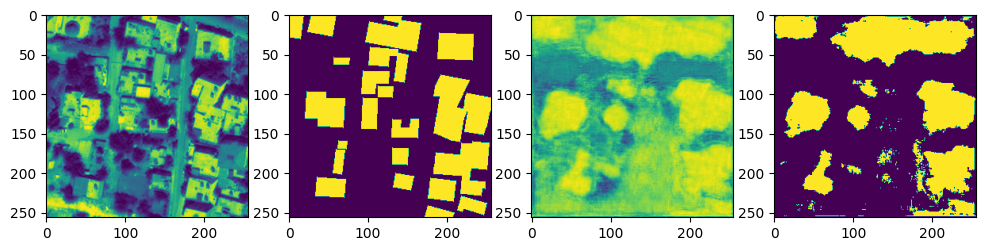

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.subplot(1, 4, 1)
plt.imshow(valid_dataset[i][0][0])
plt.subplot(1, 4, 2)
plt.imshow(valid_dataset[i][1])
plt.subplot(1, 4, 3)

plt.imshow(pred)
plt.subplot(1, 4, 4)
plt.imshow(result)

plt.show()
